In [1]:
import tensorflow as tf

### Managing graph
Below code doesn't do any computation or any variable initilization. It just creates a computation graph. To evaluate the 'f', we need to open a Tensorflow session and use it to initilize the variables and evaluate the f and then close the session.

In [2]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

### Initialize the session and variables

In [3]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result1 = sess.run(f)
print(result1)
sess.close()

42


### Different way to initialize session and variables
1. To avoid repetitive *sess.run()*, we can run with *'with*' block, where the session is set as a default session.
2. *x.initializer.run()* is equivalent to *tf.get_default_session.run(x.initializer)*
3. f.eval() is equivalent to *tf.get_default_session.run(f)*
4. The session is automatically created and closed.

In [4]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result2 = f.eval()
print(result2)

42


### Avoiding initializing each variable in a session
1. We can avoid running initializer for each variable by using *global_variables_initiazlier()* function.
2. This doesn't perform the initialization immediately, but rather creates a node in the graph that will initialize all the variables when it is run.

In [5]:
init = tf.global_variables_initializer() #prepare an init node

with tf.Session() as sess:
    init.run() #actually initialize all the variables
    result3 = f.eval()
print(result3)

42


### Initializing Interactive session for jupyter
1. Difference between regular session and interactive session is that when an InteractiveSession is created it automatically sets itself as the default session.
2. We don't need a *'with'* block
3. We need to close the session manually when we are done with the session.

In [6]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()
result4 = f.eval()
print(result4)
sess.close()

42


Tensorflow programs are usually split into two parts. 
1. Computation graph (construction phase)
2. Running it (execution phase)

Construction phase typically builds a computation graph representing the ML and the computations required to train it.

Execution phase generally runs a loop that evaluates a training step repeatedly (for example, one step per mini-batch), gradually imporving the model parameters.

# Managing Graphs

1. Any node created will be automatically added to default graph
2. To manage multiple graphs independent graphs, we need to create new graph.
3. Temporarily a graph can be made default by creating nodes within the *'with'* block
4. Default graph can be reset by running *tf.reset_default_graph()*

In [7]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [8]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


# Lifecycle of a Node Value
1. Tensor flow checks the dependenant nodes before evaluating the nodes that are called.
2. All the node values are dropped between the graph runs, except variable values, which are maintained by the session across graph runs.
3. Variable starts its life when its initializer is run, and it ends when the session is closed.
4. In a single process Tensorflow, mulitple sessions do not share any state, even if they resuse the same graph (each session would have its own copy of every variable)
5. In distributed Tensorflow, variable state is stored on the servers, not in the sessions, so multiple sessions can share the same variable.

In [9]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x + 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
8
10
8


### Tensorflow Operations

1. Tensorflow operations can take any number of inputs and produce any number of outputs.
2. Simply called as **ops**
3. Addition and Multiplication ops can take two inputs and produce one output
4. Constant ops take no inputs and also called as *source ops*
5. Inputs and outputs are called multidimensional arrays called tensors. Tesors have shape and type.

### Linear Regression in Tensorflow

In [10]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing["data"]]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name = "X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name = "y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = sess.run(theta)

In [11]:
theta_value

array([[ -3.74651413e+01],
       [  4.35734153e-01],
       [  9.33829229e-03],
       [ -1.06622010e-01],
       [  6.44106984e-01],
       [ -4.25131839e-06],
       [ -3.77322501e-03],
       [ -4.26648885e-01],
       [ -4.40514028e-01]], dtype=float32)

### Linear Regression with Numpy

In [12]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)

theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
theta_numpy

array([[ -3.69419202e+01],
       [  4.36693293e-01],
       [  9.43577803e-03],
       [ -1.07322041e-01],
       [  6.45065694e-01],
       [ -3.97638942e-06],
       [ -3.78654265e-03],
       [ -4.21314378e-01],
       [ -4.34513755e-01]])

### Linear Regression with Scikit-Learn

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1,1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


# Implementing Gradient Descent
#### Normalizing input features before performing gardient descent

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

#### Manually computing Gradients using Tensorflow

In [15]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


In [16]:
best_theta

array([[  2.06855226e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845096e-01],
       [  1.64778158e-01],
       [  7.44080753e-04],
       [ -3.91945168e-02],
       [ -8.61356616e-01],
       [ -8.23479712e-01]], dtype=float32)

### Using autodiff
1. It is not always easy to derive gradient from the cost function
2. It becomes difficult, tedious and error prone to derive gradient
3. Example: *gradients = tf.gradients(mse, [theta])[0]*
4. The *gradients()* function take an op(in this case mse) and a list of variables(in this case just theta), and it crates a list of ops(one per variable) to compute the gradients of the op with regards to each variable. So the gradients node will compute the gradient vector of the MSE with regards to *theta.*

In [17]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0] #Changed code here for autodiff
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    
best_theta

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


array([[  2.06855249e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845066e-01],
       [  1.64778143e-01],
       [  7.44078017e-04],
       [ -3.91945094e-02],
       [ -8.61356676e-01],
       [ -8.23479772e-01]], dtype=float32)

### Using Tensorflow out of the box Gradient Descent Optimizer

In [18]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # Optimizier
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    
best_theta

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


array([[  2.06855249e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845066e-01],
       [  1.64778143e-01],
       [  7.44078017e-04],
       [ -3.91945094e-02],
       [ -8.61356676e-01],
       [ -8.23479772e-01]], dtype=float32)

### Using out of the box Momentum optimizer

In [19]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9) # Optimizier
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    
best_theta

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.527316
Epoch 200 MSE = 0.524414
Epoch 300 MSE = 0.524328
Epoch 400 MSE = 0.524322
Epoch 500 MSE = 0.524321
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.52432
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321


array([[ 2.06855798],
       [ 0.82961673],
       [ 0.11875112],
       [-0.26552212],
       [ 0.30569226],
       [-0.00450316],
       [-0.03932616],
       [-0.89989167],
       [-0.87054664]], dtype=float32)

# Feeding data to the Training Algorithm

#### placeholder() function:
1. In context of mini batch gradient descent, we need a way to replace X and y at every iteration with the next mini batch. This can be easily done with tensorflow placeholders
2. These nodes are special because they don't actually perform any computation, they just output the data ou tell them to output at runtime.
3. Placeholders are typically used to pass training data to Tensorflow during training. 
4. We should specify a value at runtime for a placeholder, or we will get an exception.
5. Optionally, size of the placeholder can initially set.

In [20]:
# Using placeholder() function
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5

with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1,2,3]]})
    B_val_2 = B.eval(feed_dict={A: [[4,5,6], [7,8,9]]})

print(B_val_1)
print(B_val_2)

[[ 6.  7.  8.]]
[[  9.  10.  11.]
 [ 12.  13.  14.]]


### Implementing Mini Batch Gradient Descent

In [21]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    
best_theta    

array([[ 2.07144761],
       [ 0.84620118],
       [ 0.11558535],
       [-0.26835832],
       [ 0.32982782],
       [ 0.00608358],
       [ 0.07052915],
       [-0.87988573],
       [-0.86342508]], dtype=float32)

# Saving and Restoring Models
1. Once models are trained, we need to save parameters to disk to compare different models performance.
2. To retrieve parameters if your model crashes during training.
3. Need to save checkpoints at regular intervals to recover if model crashes during training phase.
4. Need to create a Saver node at the end of construction phase and then in the execution phase call *save()* method when ever we want to save the model
5. Restoring a model is also easy. Just need to start the session with *saver.restore("path")* instead of *sess.run(init)*
6. By default a Saver node saves and restores all the variables under their own name, but we can change their names when saving them as saver = tf.train.Saver({"weights": theta})
7. *saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")*

# Visualizing the Graphs
### Inside Jupyter

In [22]:
tf.reset_default_graph()
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph().as_graph_def())

In [23]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, sess.graph)

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:                                                       
    sess.run(init)                                                                

    for epoch in range(n_epochs):                                                 
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    
file_writer.close()

In [24]:
best_theta

array([[ 2.07001591],
       [ 0.82045609],
       [ 0.1173173 ],
       [-0.22739051],
       [ 0.31134021],
       [ 0.00353193],
       [-0.01126994],
       [-0.91643935],
       [-0.87950081]], dtype=float32)

In [25]:
#python -m tensorflow.tensorboard --logdir=path/to/log-directory
#http://localhost:6006
#python -m tensorflow.tensorboard --logdir='E:\GitHub Main\Python-Handson-Projects\tf_logs\run-20170803181200\'

### Name Scopes
1. A Name Scope is used to create a group of related nodes.
2. Name scopes avoid cluttering of tensorboard graphs when there are many graphs in a NN
3. Below code modifies the *error* and *mse* nodes and places them within *loss* name scope.

In [26]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size) 
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

tf.reset_default_graph()
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed = 42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m/batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)       

Best theta:
[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


In [27]:
print(error.op.name)
print(mse.op.name)

loss/sub
loss/mse


In [28]:
tf.reset_default_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


### Modularity and Sharing Variables
Check out https://github.com/ageron/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb

#### Exercise Problem 12

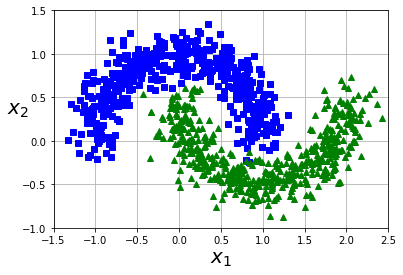

In [29]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

m = 1000
X, y = make_moons(n_samples=m, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [30]:
bias = np.ones((m, 1))
X_plus_bias = np.c_[bias, X]
y_columns = y.reshape(-1, 1)

test_ratio = 0.2
test_size = int(test_ratio * m)
X_train = X_plus_bias[: -test_size]
y_train = y_columns[: -test_size]
X_test = X_plus_bias[-test_size:]
y_test = y_columns[-test_size:]

In [31]:
tf.reset_default_graph()
n_epochs = 1000
learning_rate = 0.01
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

X = tf.placeholder(tf.float32, shape=(None, 3), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0, seed=42), name="theta")
logit = tf.matmul(X, theta, name="logit")
y_proba = 1/(1+tf.exp(-logit))
loss = tf.losses.log_loss(y, y_proba)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.873796
Epoch: 100 	Loss: 0.355813
Epoch: 200 	Loss: 0.317708
Epoch: 300 	Loss: 0.30348
Epoch: 400 	Loss: 0.296114
Epoch: 500 	Loss: 0.292612
Epoch: 600 	Loss: 0.290987
Epoch: 700 	Loss: 0.290265
Epoch: 800 	Loss: 0.289575
Epoch: 900 	Loss: 0.288969


In [32]:
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", precision_score(y_test, y_pred))

Precision: 0.839622641509
Recall: 0.839622641509


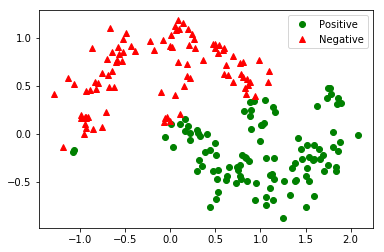

In [33]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Epoch: 0 	Loss: 0.813711
Epoch: 1000 	Loss: 0.148764
Epoch: 2000 	Loss: 0.111983
Epoch: 3000 	Loss: 0.0945872
Epoch: 4000 	Loss: 0.084471
Epoch: 5000 	Loss: 0.0778293
Epoch: 6000 	Loss: 0.0730102
Epoch: 7000 	Loss: 0.0693926
Epoch: 8000 	Loss: 0.0666399
Epoch: 9000 	Loss: 0.0644411
Epoch: 10000 	Loss: 0.0626493
Precision: 0.979797979798
Recall: 0.979797979798


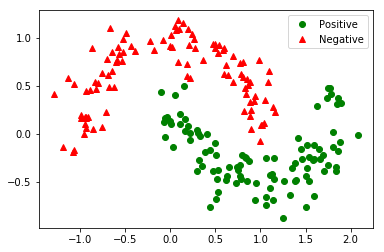

In [34]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

m = 1000
X, y = make_moons(n_samples=m, noise=0.15, random_state=42)

bias = np.ones((m, 1))
X_plus_bias = np.c_[bias, X, X[:,0]**2, X[:,1]**2, X[:,0]**3, X[:,1]**3]
y_columns = y.reshape(-1, 1)

test_ratio = 0.2
test_size = int(test_ratio * m)
X_train = X_plus_bias[: -test_size]
y_train = y_columns[: -test_size]
X_test = X_plus_bias[-test_size:]
y_test = y_columns[-test_size:]

tf.reset_default_graph()
n_epochs = 10001
learning_rate = 0.01
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

X = tf.placeholder(tf.float32, shape=(None, 7), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([7, 1], -1.0, 1.0, seed=42), name="theta")
logit = tf.matmul(X, theta, name="logit")
y_proba = 1/(1+tf.exp(-logit))
loss = tf.losses.log_loss(y, y_proba)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 1000 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})
    
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", precision_score(y_test, y_pred))

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()